# Collaborative Filtering for Implicit Feedback Datasets

### Cost function for squared error with regularization

Across all x (users) and y (items), find the values of u and i that minimize the summation below:

$\underset{x,y}min\underset{u,i}\sum 
c_{ui} (p_{ui} - x_u^Ty_i)^2 + \lambda
(\underset u \sum \parallel x_u \parallel ^2
+\underset u \sum \parallel y_i \parallel ^2)$

##### Where:

$x_u$ is user vector,
$y_i$ is item vector.

$p_{ui} = 1$ if interaction, 
$p_{ui} = 0$ if no interaction.

$c_{ui} = 1 + \alpha * r_{ui}$, where
$r_{ui}$ = # of interactions for a user-item pair, and $\alpha$ determines our confidence levels.

$\lambda$ is regularization term.

#### Explanation of cost function

We take the squared error of our prediction and 
multiply by the confidence, and regularize our $x$ and $y$ vectors with $\lambda$ to penalize overfitting. (larger values or smaller values?)

$\alpha$ allows us to influence our confidence levels. Clearly, our confidence increases when a producer samples the same artist multiple times, but by how much? $\alpha$ determines how important multiple samples are.

We add 1 so that non-interactions are not lost during the cost calculation.

### ALS Algorithm

However, we can't use the cost function above because of the size of the dataset. (m * n terms)

Therefore we modify the cost function to Alternating Least Squares, which works by holding either user vectors or item vectors constant and calculating the global minimum, then alternating to the other vector.

#### Compute user factors

$x_u = (Y^T C^u Y + \lambda I)^{-1}  Y^T C^u p(u)$

##### Where:

$Y$ is $n * f$ matrix of item-factors. 

$C^u$ is a $n*n$ diagonal matrix for user $u$ where $C^u_{ii} = c_{ui}$. Each $C^u$ is our confidence matrix for $n$ items for $u$ user.

$p(u)$ is vector of preferences for user $u$.


#### Recompute item factors

$y_i = (X^TC^iX + \lambda I)^-1 X^TC^ip(i)$

##### Where:
$X$ = $m * f$ matrix  of user_factors. 

$C^i$ is $m * m$ diagonal matrix for each item $i$ where $C_{uu}^i = c_{ui}$

$p(i)$ is vector of preferences for item $i$.

### Explaining recommendations

If $\hat{p}_{ui}$, the predicted preference of user $u$ at item $i$, is equal to $y_i^Tx_u$, we can substite our user_factor equation for $x_u$. This gives us:

$\hat{p}_{ui} =  y_i^T(Y^T C^u Y + \lambda I)^{-1}  Y^T C^u p(u)$

Denote $f*f$ matrix $(Y^T C^u Y + \lambda I)^{-1}$ as $W^u$

$W^u$ is considered the weight for user $u$


## Import libaries and utility matrix

In [1]:
from pymongo import MongoClient
client = MongoClient()
db = client.whosampled
import numpy as np
import pandas as pd

import implicit
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import scipy.sparse as sparse
from scipy.sparse import csr_matrix

import os, sys
os.environ["OPENBLAS_NUM_THREADS"]="1"

import random

from src.turn_db_main_into_utility_matrix import from_mongo_collection_to_utility_matrix

np.set_printoptions(threshold=sys.maxsize)
# Read in the data from the Mongo collection

prod_artist, df = from_mongo_collection_to_utility_matrix(db.main_redo)

### Perform Test/Train Split

We can't do the traditional time split for recommendation systems, because the algorithm requires the entire
dataframe to train on. Instead, we create a test set by taking some percentage of the actual interactions, and 
replacing them with zeros- in other words, acting as if the producer has not sampled those artists.

We train the model on this `train` dataset with these specific values hidden. 

In [2]:
def get_indices_of_test_set_values(ui_util_mat, percent):
    
    '''
    Given a utility matrix and a desired train/test split, returns two lists:
    The row and column indices of the test set data.
    
    Indices should be in user, item form- therefore, matrix needs to be in user_item form.
    
    '''
    
    #Get all nonzero inds in our utility matrix. This is two lists of row/pair indices.
    nonzero_inds = ui_util_mat.values.nonzero()
        
    # Turn into list of tuples
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))

    # Num_samples is percent % of len(interactions)
    num_samples = int(np.ceil((percent/100)*len(nonzero_pairs))) 
    
    # Take a % of these as a test set. 
    samples = random.sample(nonzero_pairs, num_samples) 
    
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    
    return user_inds, item_inds

def make_train_set_and_test_set(user_inds, item_inds, ui_util_mat):
    '''
    Creates training set with all the values at the test set indices 
    replaced with zeros.
    
    Before doing this, copies train set to test set.
    '''
    train = ui_util_mat.copy()
    test = ui_util_mat.copy()
    
    train.iloc[user_inds, item_inds] = 0
    
    return train, test

In [3]:
user_inds, item_inds = get_indices_of_test_set_values(prod_artist, 10)

train, test = make_train_set_and_test_set(user_inds, item_inds, prod_artist)

## Fit model on training data 

The implicit library has a fast implementation of the alternating least squares algorithm, which I use below. 

The model's fit method expects the sparse utility matrix to be as item/user- however, ours is in user-item.

Therefore, the model's item_vecs is our user_vecs, and vice versa.

In [10]:
train_model = implicit.als.AlternatingLeastSquares(factors=100,iterations=15)

# train the model on a sparse matrix of user/item/confidence weights
sparse_train = csr_matrix(train)
train_model.fit(sparse_train)

100%|██████████| 15.0/15 [00:04<00:00,  2.80it/s]


## Explore Model

The item factors attribute refers to our user_vectors, since we trained it backwards

To explore the recommendations and other attributes, will probably be simplest to retrain the model with a item_user matrix.

In [15]:
user_vecs = train_model.item_factors.shape

train_model.

(16865, 100)

## Test model

We need a metric to evaluate how our model is performing on the test data.
### Ranking Algorithm

$\overline{rank} = \frac{\sum_{u,i} r^t_{ui} * rank_{ui}}{\sum_{u,i} r^t_{ui}}$

#### where:
$r^t_{ui}$ is the # of interactions for observations in the test set, and 

$rank_{ui}$ are the percentile ranking of each item for each user.

#### Explanation

We can see that $\sum_{u,i} r^t_{ui}$ is in both the numerator and the denominator. If $rank_{ui}$ was not in the numerator, $\overline{rank}$ would simply equal 1. $rank_{ui}$ is the percentile ranking of each item for each user, such that the item most highly recommended has a $rank_{ui}$ of 0.00\% and the item least recommended has a $rank_{ui}$ of 100.00\%.

Therefore, if the algorithm is correct, the low percentages will cancel out the high $r^t_{ui}$, making the $\overline{rank}$ go towards 0.

#### Methodology

1. Get denominator by summing the # of user-item interactions at the test set indices. This is $\sum_{u,i} r^t_{ui}$, for  $\overline{rank} = \frac{\sum_{u,i} r^t_{ui} * rank_{ui}}{\sum_{u,i} r^t_{ui}}$   

2. Get the $rank_{ui}$ of our model for all $u, i$ in $r^t_{ui}$. This is calculated by getting the predictions of the ALS model, ranking them, taking their percentage, and then selecting only the ones at the selected indices.

3. Get rtui 

4. Multiply $rank_{ui}$ by $r^t_{ui}$ to get numerator. Divide by $rank_{ui}$ to get $\overline{rank}$

5. Use popularity as a baseline for the model. Instead of using the model to rank different songs for artists, the $rank_{ui}$ of popularity for all $u, i$ in $r^t_{ui}$. This is popularity rank score.

1. Get denominator by summing the # of user-item interactions at the test set indices. This is $\sum_{u,i} r^t_{ui}$, for  $\overline{rank} = \frac{\sum_{u,i} r^t_{ui} * rank_{ui}}{\sum_{u,i} r^t_{ui}}$ 

In [4]:
def get_denominator_for_rank_algorithm(user_inds, item_inds, test):
    '''
    Given a list of row indices, list of column indices, and a test dataset, 
    sums up the values in the utility matrix at these indices. This is the 
    denominator of the ranking algorithm.
    
    It is the r value, in the test set, at indices u, i, summed.
    '''
    
    #Get the denominator value for ranking algorithm.
    total_score = []
    for i in range(len(user_inds)):

        score = test.iloc[user_inds[i], item_inds[i]]
        total_score.append(score)
    denominator = sum(total_score)
    return denominator

2. Get the $rank_{ui}$ of our model for all $u, i$ in $r^t_{ui}$. This is calculated by getting the predictions of the ALS model, ranking them, taking their percentage, and then selecting only the ones at the selected indices.

3. Get $r^t_{ui}$

In [5]:
def get_rank_ui(model, user_inds, item_inds):
    
    '''
    Takes a fitted model and calculates the ranking of recommendation for every item
    for every user. This is then turned into a percentage.
    
    Indices refer to the indices of the test set. We thus filter our rankings
    to only look at the test set.
    '''
    
    # The model is set to train on item/user/confidence weights. 
    #But I am training it on user/item.
    user_vecs = model.item_factors
    item_vecs = model.user_factors
    
    #predictions is user, items
    predictions = user_vecs.dot(item_vecs.T)
    
    #print(predictions.shape)
    #get the rank of each item for each user
    #Use axis =1 to sort across, across the artists for each producer.
    order = np.flip(predictions.argsort(axis = 1), axis = 1)
    ranks = order.argsort(axis = 1)

    #turn ranks into percentages
    rank_ui = ranks / ranks.shape[0]
    
    rank_ui = rank_ui[user_inds, item_inds].reshape(-1, 1)
    return rank_ui

def get_rui(ui_util_mat, user_inds, item_inds):
    rui = ui_util_mat.values[user_inds, item_inds].reshape(-1,1)
    return rui

4. Multiply $rank_{ui}$ by $r^t_{ui}$ to get numerator. Divide by $rank_{ui}$ to get $\overline{rank}$

In [6]:
def get_rank_score(r_ui, rank_ui, denominator):
    
    '''
    Requires r_ui to be in form users, items.
    '''
    
    numerator = r_ui * rank_ui

    numer_summation = np.sum(numerator)

    rank = numer_summation / denominator
    return rank


## Compare to baseline: Just recommend what's popular.

In [7]:
# What if you just recommend the most popular?

# Get most popular items in the mat

def get_pop_rank_ui(test, item_inds):
    
    '''
    Returns pop_rank_ui for test data. It counts the samples per artist,
    then ranks the artists by their number of samples. 
    
    As before, we only need the percentages for the item_inds
    '''
    
    samples_per_artist = test.sum(axis = 0)
    order = np.flip(samples_per_artist.values.argsort(), axis = 0)
    ranks = order.argsort()

    pop_rank_ui = ranks / len(samples_per_artist)
    pop_rank_ui = pop_rank_ui[item_inds].reshape(-1,1)
    
    return pop_rank_ui

## Putting it all together

In [8]:
#1
denominator = get_denominator_for_rank_algorithm(user_inds, item_inds, test)

#3
rui = get_rui(test, user_inds, item_inds)

def get_rank_score_from_train_test_model(train, test, denominator, user_inds, item_inds, rui, factors):
    '''
    Takes a train and test set, fits a ALS model to the train set.
    Returns rank_scores for the model and popularity(baseline)
    '''
    
    #initialize a new model
    train_model = implicit.als.AlternatingLeastSquares(factors=factors,iterations=15)

    # train the model on a sparse matrix of user/item/confidence weights
    sparse_train = csr_matrix(train)
    train_model.fit(sparse_train)

    #2
    rank_ui = get_rank_ui(train_model, user_inds, item_inds)

    #4
    rank_score = get_rank_score(rui, rank_ui, denominator)

    return rank_score

def get_pop_rank_score(test, item_inds, denominator):
    
    pop_rank_ui = get_pop_rank_ui(test, item_inds)
    pop_rank_score = get_rank_score(rui, pop_rank_ui, denominator)
    return pop_rank_score



In [9]:
rank_score = get_rank_score_from_train_test_model(train, test, denominator, user_inds, item_inds, rui, 100)
pop_rank_score = get_pop_rank_score(test, item_inds, denominator)
print(
"Model rank score: {} \n\
Popularity rank score: {}".format(rank_score, pop_rank_score))

100%|██████████| 15.0/15 [00:04<00:00,  3.39it/s]


Model rank score: 0.2582853103766358 
Popularity rank score: 0.09149419419276691


## Evaluation
My model does not do as well as popularity unfortunately.

# Testing at different # of factors

In [10]:
denominator = get_denominator_for_rank_algorithm(user_inds, item_inds, test)
rui = get_rui(test, user_inds, item_inds)

rank_scores = []

for factors in range(20, 200, 20):
    rank_score = get_rank_score_from_train_test_model(train, test, denominator, user_inds, item_inds, rui, factors)
    rank_scores.append(rank_score)

100%|██████████| 15.0/15 [00:02<00:00,  5.10it/s]
100%|██████████| 15.0/15 [00:03<00:00,  4.49it/s]
100%|██████████| 15.0/15 [00:16<00:00,  1.26s/it]
100%|██████████| 15.0/15 [00:32<00:00,  1.93s/it]
100%|██████████| 15.0/15 [01:00<00:00,  4.33s/it]
100%|██████████| 15.0/15 [00:24<00:00,  1.49s/it]
100%|██████████| 15.0/15 [00:23<00:00,  1.61s/it]
100%|██████████| 15.0/15 [00:29<00:00,  2.16s/it]
100%|██████████| 15.0/15 [00:30<00:00,  2.10s/it]


In [11]:
printt(rank_scores)

[0.2940623219228713, 0.269905864227716, 0.27224765688382563, 0.2667204962781687, 0.25981336320582477, 0.2610372850539453, 0.2595565874163721, 0.26250588422436777, 0.26790017896563467]


## Go through None Listed on producers

#### How many have all None Listed?
33 percent have none Listed for producers!

If they have None Listed for contributor (about 40), that probably means it failed. Because contributor is always listed.

Certain artists have more none listed than others.

Nearly 10,000 of the cells with missing producers are where the artists only occurs once in the df.

From the pie chart, nearly 3/4 of the missing producers are from artists who appear only 3 or less times in the dataset.


In [16]:
df=pd.DataFrame(list(db.main_redo.find()))

In [41]:
for col in df.columns:
    print("{} has {} with None Listed".format(col, len(df[df[col] == "None Listed" ])))



URL has 0 with None Listed
_id has 0 with None Listed
contributor_points has 40 with None Listed
elements_sampled has 36 with None Listed
name_of_contributor has 40 with None Listed
new_song_album has 18326 with None Listed
new_song_artist has 33 with None Listed
new_song_name has 33 with None Listed
new_song_producer has 63939 with None Listed
new_song_year has 34 with None Listed
presence_of_"and throughout"_in_description has 14647 with None Listed
sampled_artist has 1207 with None Listed
sampled_song_album has 19869 with None Listed
sampled_song_name has 1207 with None Listed
sampled_song_producer has 7 with None Listed
sampled_song_year has 2892 with None Listed
time_in_sampled_song_where_sample_appears has 14653 with None Listed


In [118]:
# Get the number of cells that are missing producer information
# for each new_song_artist and sort by artist with most missing.

df_none_listed_counts_per_artist = df[df.new_song_producer == "None Listed" ].\
    groupby("new_song_artist").\
    count()['URL'].sort_values(ascending = False)



In [132]:
df_none_listed_counts_per_artist[df_none_listed_counts_per_artist == 2]

new_song_artist
Orleya                    2
Karen Aoki                2
Don Cephas                2
Le Knight Club            2
Papa J. Smoove            2
Matty G                   2
Daniel Caesar             2
Daniel Padilla            2
Le Le                     2
DJ Bass Boy               2
Daniel Pemberton          2
Lisa Lashes               2
Mister Bond               2
Daniel Russell            2
D-Train                   2
Le Youth                  2
David T. Walker           2
Origination               2
Mobonix                   2
Lisa Nilsson              2
Paola Casella             2
King Johnny Fresh         2
Karen Clark Sheard        2
Lane 8                    2
Metrik                    2
Landon Austin             2
Kool Kay Dee              2
D-Town Funk               2
D-Pulse                   2
Midfield General          2
                         ..
Slowdive                  2
Fire Flowerz              2
Sentidos Apuestos         2
C-Funk                    2
Scar

In [122]:
# bin the none_listed_counts_per_artist, and take the mean and count
# of each bin

mean_per_bin = df_none_listed_counts_per_artist.groupby(
    pd.cut(df_none_listed_counts, [0,1, 2,3,4,5, 20, 100,200, 500, 1000,np.infty])).\
    mean()

counts_per_bin = df_none_listed_counts.value_counts().groupby(
    pd.cut(df_none_listed_counts.value_counts().
    index, [0,1, 2,3,4,5, 20, 100,200, 500, 1000,np.infty])).\
    sum()

# Mulitply together to the number of missing values 

num_cells_missing_prod_by_num_artist = mean_per_bin * counts_per_bin

#This has the correct sum, showing that this methodology was successful.

In [127]:
sum(num_cells_missing_prod_by_num_artist)

63939.0

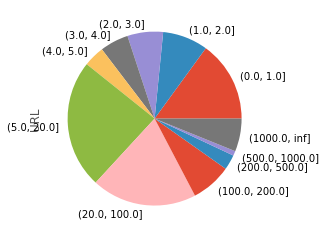

In [126]:
_ = num_cells_missing_prod_by_num_artist.plot(kind='pie')
# yo = pd.cut(df_none_listed_counts.value_counts().index, [0,1, 2,3, np.infty])

In [92]:
yo.value_counts()

(0.0, 1.0]      1
(1.0, 2.0]      1
(2.0, 3.0]      1
(3.0, inf]    122
dtype: int64

In [90]:
yo.plot(kind='pie')

AttributeError: 'Categorical' object has no attribute 'plot'

# Split the data into 2016 after and before.


In [4]:
# What percentage of the data is 2018, 2017, etc?

np.cumsum(df.groupby('new_song_year').count()['URL'].apply(
    lambda x: (x / len(df)) * 100 ).sort_index(
    ascending = False))

# If we take the data past 2016-2019 as our test set, we get about 5%.

new_song_year
2019      0.127584
2018      1.752243
2017      3.614425
2016      5.619121
2015      8.069004
2014     10.856848
2013     14.537780
2012     18.091127
2011     21.231863
2010     24.333238
2009     26.670467
2008     29.158353
2007     31.654383
2006     34.037759
2005     36.783528
2004     39.245626
2003     41.907244
2002     44.100601
2001     46.638707
2000     49.208030
1999     52.375911
1998     55.539721
1997     58.646525
1996     62.246020
1995     65.739647
1994     70.241731
1993     74.872755
1992     80.081979
1991     84.847374
1990     88.833693
           ...    
1982     98.813741
1981     98.892463
1980     98.946754
1979     99.013261
1978     99.082482
1977     99.134058
1976     99.201922
1975     99.280644
1974     99.363438
1973     99.455732
1972     99.523596
1971     99.611819
1970     99.686469
1969     99.771978
1968     99.857486
1967     99.892775
1966     99.929422
1965     99.940280
1964     99.944352
1963     99.951138
1962     99.96335

In [280]:
test = df[df.new_song_year > 2014]
train = df[df.new_song_year < 2015]
print(test.shape)
print(train.shape)

(5945, 18)
(67732, 18)


In [297]:
# Songs and users have to be in both, right?

#get intersection of sampled_artist and song_producer from train and test set
def get_intersection_of_train_and_test_set(train, test, column):
    
    '''
    Takes train and test set and a column, and returns both filtered
    to have values they both share
    '''
    test_column = set(test[column])
    train_column = set(train[column])
    both_columns = test_column.intersection(train_column)
    print([len(test_column), len(train_column), len(both_columns)])
    
    test = test[test[column].isin(list(both_columns))]

    train = train[train[column].isin(list(both_columns))]
    
    return train, test

train, test = get_intersection_of_train_and_test_set(
    train, test, "sampled_artist")
train, test = get_intersection_of_train_and_test_set(
    train, test, "new_song_producer")

#I needed to run this 3 times to work

#I have 1163 artists, and 544 producers shared. 

[1163, 1164, 1163]
[544, 544, 544]
